In [1]:
import itertools
from collections import OrderedDict

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

tf.keras.backend.set_floatx('float64')

In [2]:
from src.layers import convolution_pooling_op, fully_connected_op, ProbExtractionLayer, PatchedTorchLayer, PatchedKerasLayer, prob_extraction

In [3]:
np.random.seed(42)
# torch.manual_seed(42)
tf.random.set_seed(42)

# Data Generation

In [4]:
def generate_dataset(num_images: int, size: int = 4, noise: float = 0.2):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = np.eye(4)[labels]
    return np.array(images), np.array(labels)

In [5]:
images, labels = generate_dataset(100, noise=0.1)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

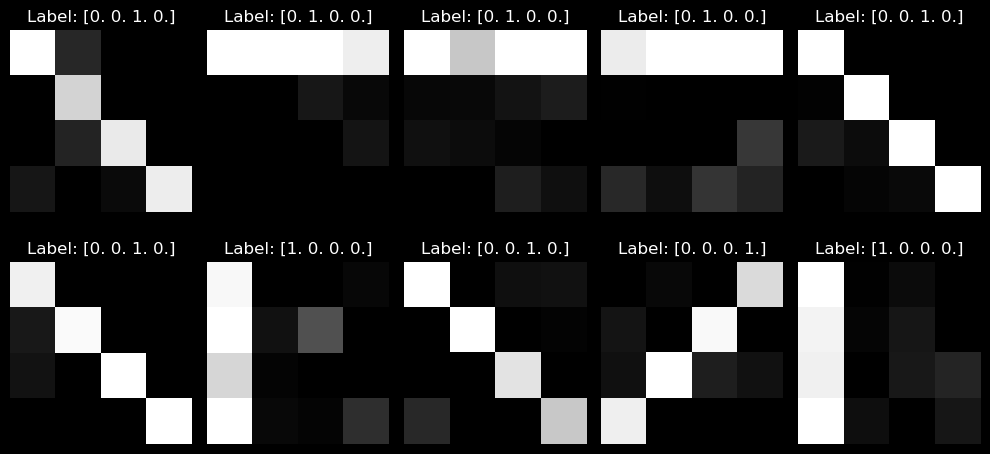

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Creating Circuit

In [7]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
B = 4
dev = qml.device("default.qubit", wires=N * N + B)
wire_arr = nnp.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2
STRIDE = 2

In [8]:
@qml.qnode(dev)
def qnode(inputs, 
          first_kernel, first_pooling, 
        #   second_kernel, second_pooling, 
          fc_weights, fc_bias):
    # Input Layer
    for i, j in itertools.product(range(N), range(N)):
        qml.RX(2 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    # convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    # reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    # return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]
    return [qml.probs(i) for i in reduced_wire_arr.flatten().tolist()]

In [9]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    # "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "fc_weights": (B - 1, B),
    "fc_bias": (B,),
}

qlayer = PatchedKerasLayer(qnode, weight_shapes, output_dim=(B,2))
qlayer

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(
2025-05-14 19:59:40.217466: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-14 19:59:40.217499: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-14 19:59:40.217506: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1747267180.217520 23712538 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747267180.217540 23712538 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Quantum Keras Layer: func=qnode>

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    qlayer,
    tf.keras.layers.Lambda(prob_extraction),
])

In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patched_keras_layer             │ (None, 4, 2)           │            28 │
│ (PatchedKerasLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (224.00 B)

 Trainable params: 28 (224.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[:3])  # Pass the first 5 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy())

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Sample output shape: (3, 4)
Sample output: [[0.47443562 0.49808081 0.45444511 0.50452389]
 [0.47258429 0.48319515 0.45419682 0.50253502]
 [0.48166303 0.50131455 0.45930637 0.49928803]]


# Model Training

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
X = torch.tensor(train_images, requires_grad=True).float()
y_hot = torch.tensor(train_labels, requires_grad=True).float()

In [ ]:
batch_size = 5
batches = 100 // batch_size
data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    
    for xs, ys in data_loader:
        opt.zero_grad()
        
        tmp = model(xs)
        loss_evaluated = loss(tmp, ys)
        loss_evaluated.backward()
        
        opt.step()
        
        running_loss += loss_evaluated
    
    avg_loss = running_loss / batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss.item():.4f}")

y_pred = model(X)
predictions = torch.argmax(y_pred, dim=1).detach().numpy()
correct = np.sum(predictions == np.argmax(train_labels, axis=1))
accuracy = correct / len(train_labels)
print(f"Training accuracy: {accuracy:.4f}")